In [20]:
import numpy as np
from scipy.signal import butter, filtfilt, hilbert, lfilter, find_peaks, welch, iirnotch
from scipy.integrate import cumtrapz, trapz
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt
import pywt

In [29]:
def extract_file_OpenBCI(file):
    array = np.genfromtxt(file + ".txt", delimiter=",",skip_header = 5)
    chs = np.transpose(array[:,1:9])
    ch0 = chs[0,:]
    ch1 = chs[1,:]
    ch2 = chs[2,:]
    ch3 = chs[3,:]
    ch4 = chs[4,:]
    ch5 = chs[5,:]
    ch6 = chs[6,:]
    ch7 = chs[7,:]
    chs = [ch0, ch1, ch2, ch3, ch4, ch5, ch6, ch7]
    return chs

def touV_byOpenBCI(ad_values, scale_factor=0.02235):
    """
    Convert OpenBCI raw ADC values to microvolts.
    
    Parameters:
    ad_values: List of ADC values from OpenBCI.
    scale_factor: Scale factor for the specific OpenBCI board (Cyton: 0.02235, Ganglion: 0.0419453125)
    
    Returns:
    List of microvolt values.
    """
    uv_values = ad_values*scale_factor
    return uv_values

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def extract_features(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    amplitude = np.max(signal) - np.min(signal)
    fft_signal = np.fft.fft(signal)
    dominant_frequency = np.argmax(np.abs(fft_signal))
    peaks, _ = find_peaks(signal)
    duration = (peaks[-1]-peaks[0])/len(signal)
    power = np.sum(np.square(signal))/len(signal)
    kurtosis = np.sum((signal - mean)**4)/(len(signal)*std**4)
    coeffs = pywt.wavedec(signal, 'db4', level = 5)
    cA5,cD5,cD4,cD3,cD2,cD1 = coeffs
    wavelet = np.concatenate((cD1, cD2, cD3, cD4, cD5))
    rms = np.sqrt(np.sum(signal * signal)/len(signal))
    area = cumtrapz(signal)
    f,P = welch(signal,fs = 1000, window='hann', noverlap=0,nfft = int(256.))
    area_freq = cumtrapz(P,f,initial=0)
    total_power = area_freq[-1]
    median_freq = f[np.where(area_freq > total_power/2)[0][0]]
    f_max = f[np.argmax(P)]
    features =  {'media': mean,
                 'desviacion_estandar': std,
                 'amplitud': amplitude,
                 'frecuencia_dominante': dominant_frequency,
                 'potencia': power,
                 'kurtosis': kurtosis,
                 'wavelet': wavelet,
                 'rms': rms,
                 'area': area,
                 'min_value': np.min(signal),
                 'max_value': np.max(signal),
                 'area_freq': area_freq,
                 'total_power': total_power,
                 'median_freq': median_freq,
                 'f_max': f_max                 
                 }
    return features

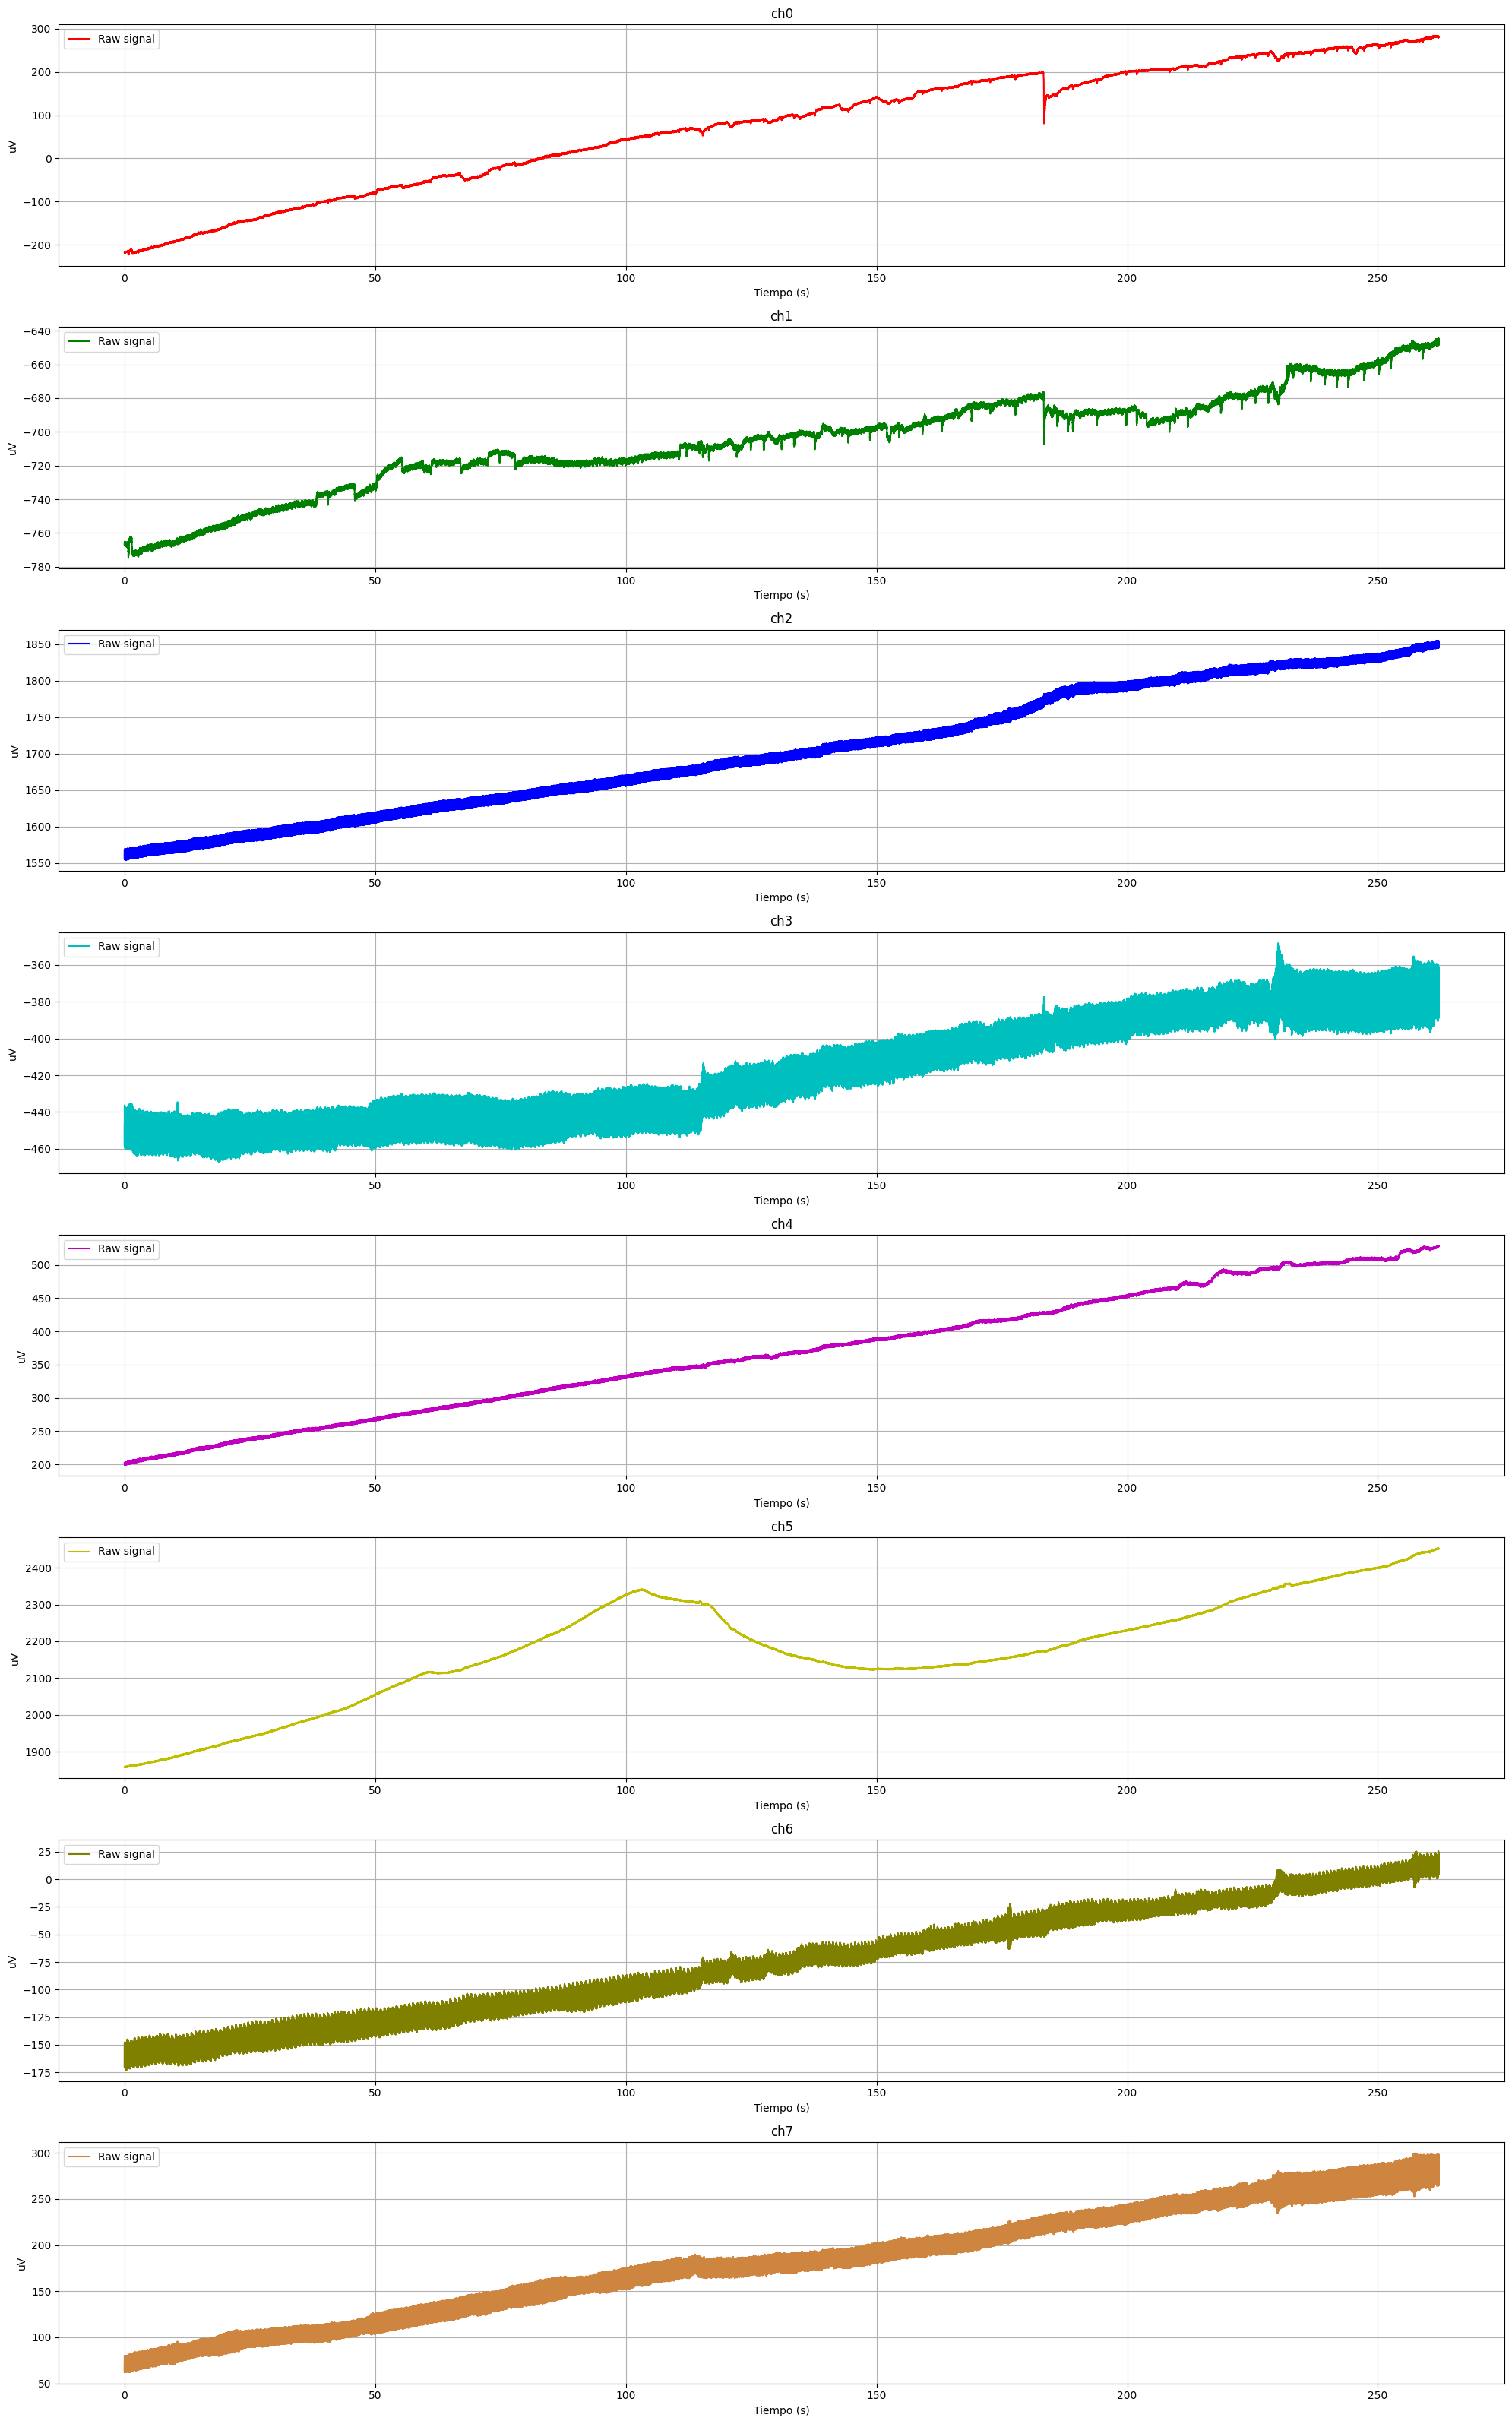

In [22]:
fs = 250; ts = 1/fs # Bitalino's sampling rate
chsRaw = extract_file_OpenBCI('OpenBCI')
time = np.arange(len(chsRaw[0]))*ts
colors = ['r','g','b','c','m','y','olive', 'peru']
fig, axs = plt.subplots(len(chsRaw), 1, figsize=(20,32))
a = 0; chs = []
for ch in chsRaw:
    ch = touV_byOpenBCI(ch)
    chs.append(ch)
    co = colors[a]
    axs[a].plot(time,ch,co, label = 'Raw signal'); axs[a].grid(True); axs[a].set(title = 'ch' + str(a), xlabel = 'Tiempo (s)', ylabel = 'uV')
    axs[a].legend()
    a += 1
plt.tight_layout()
plt.show()


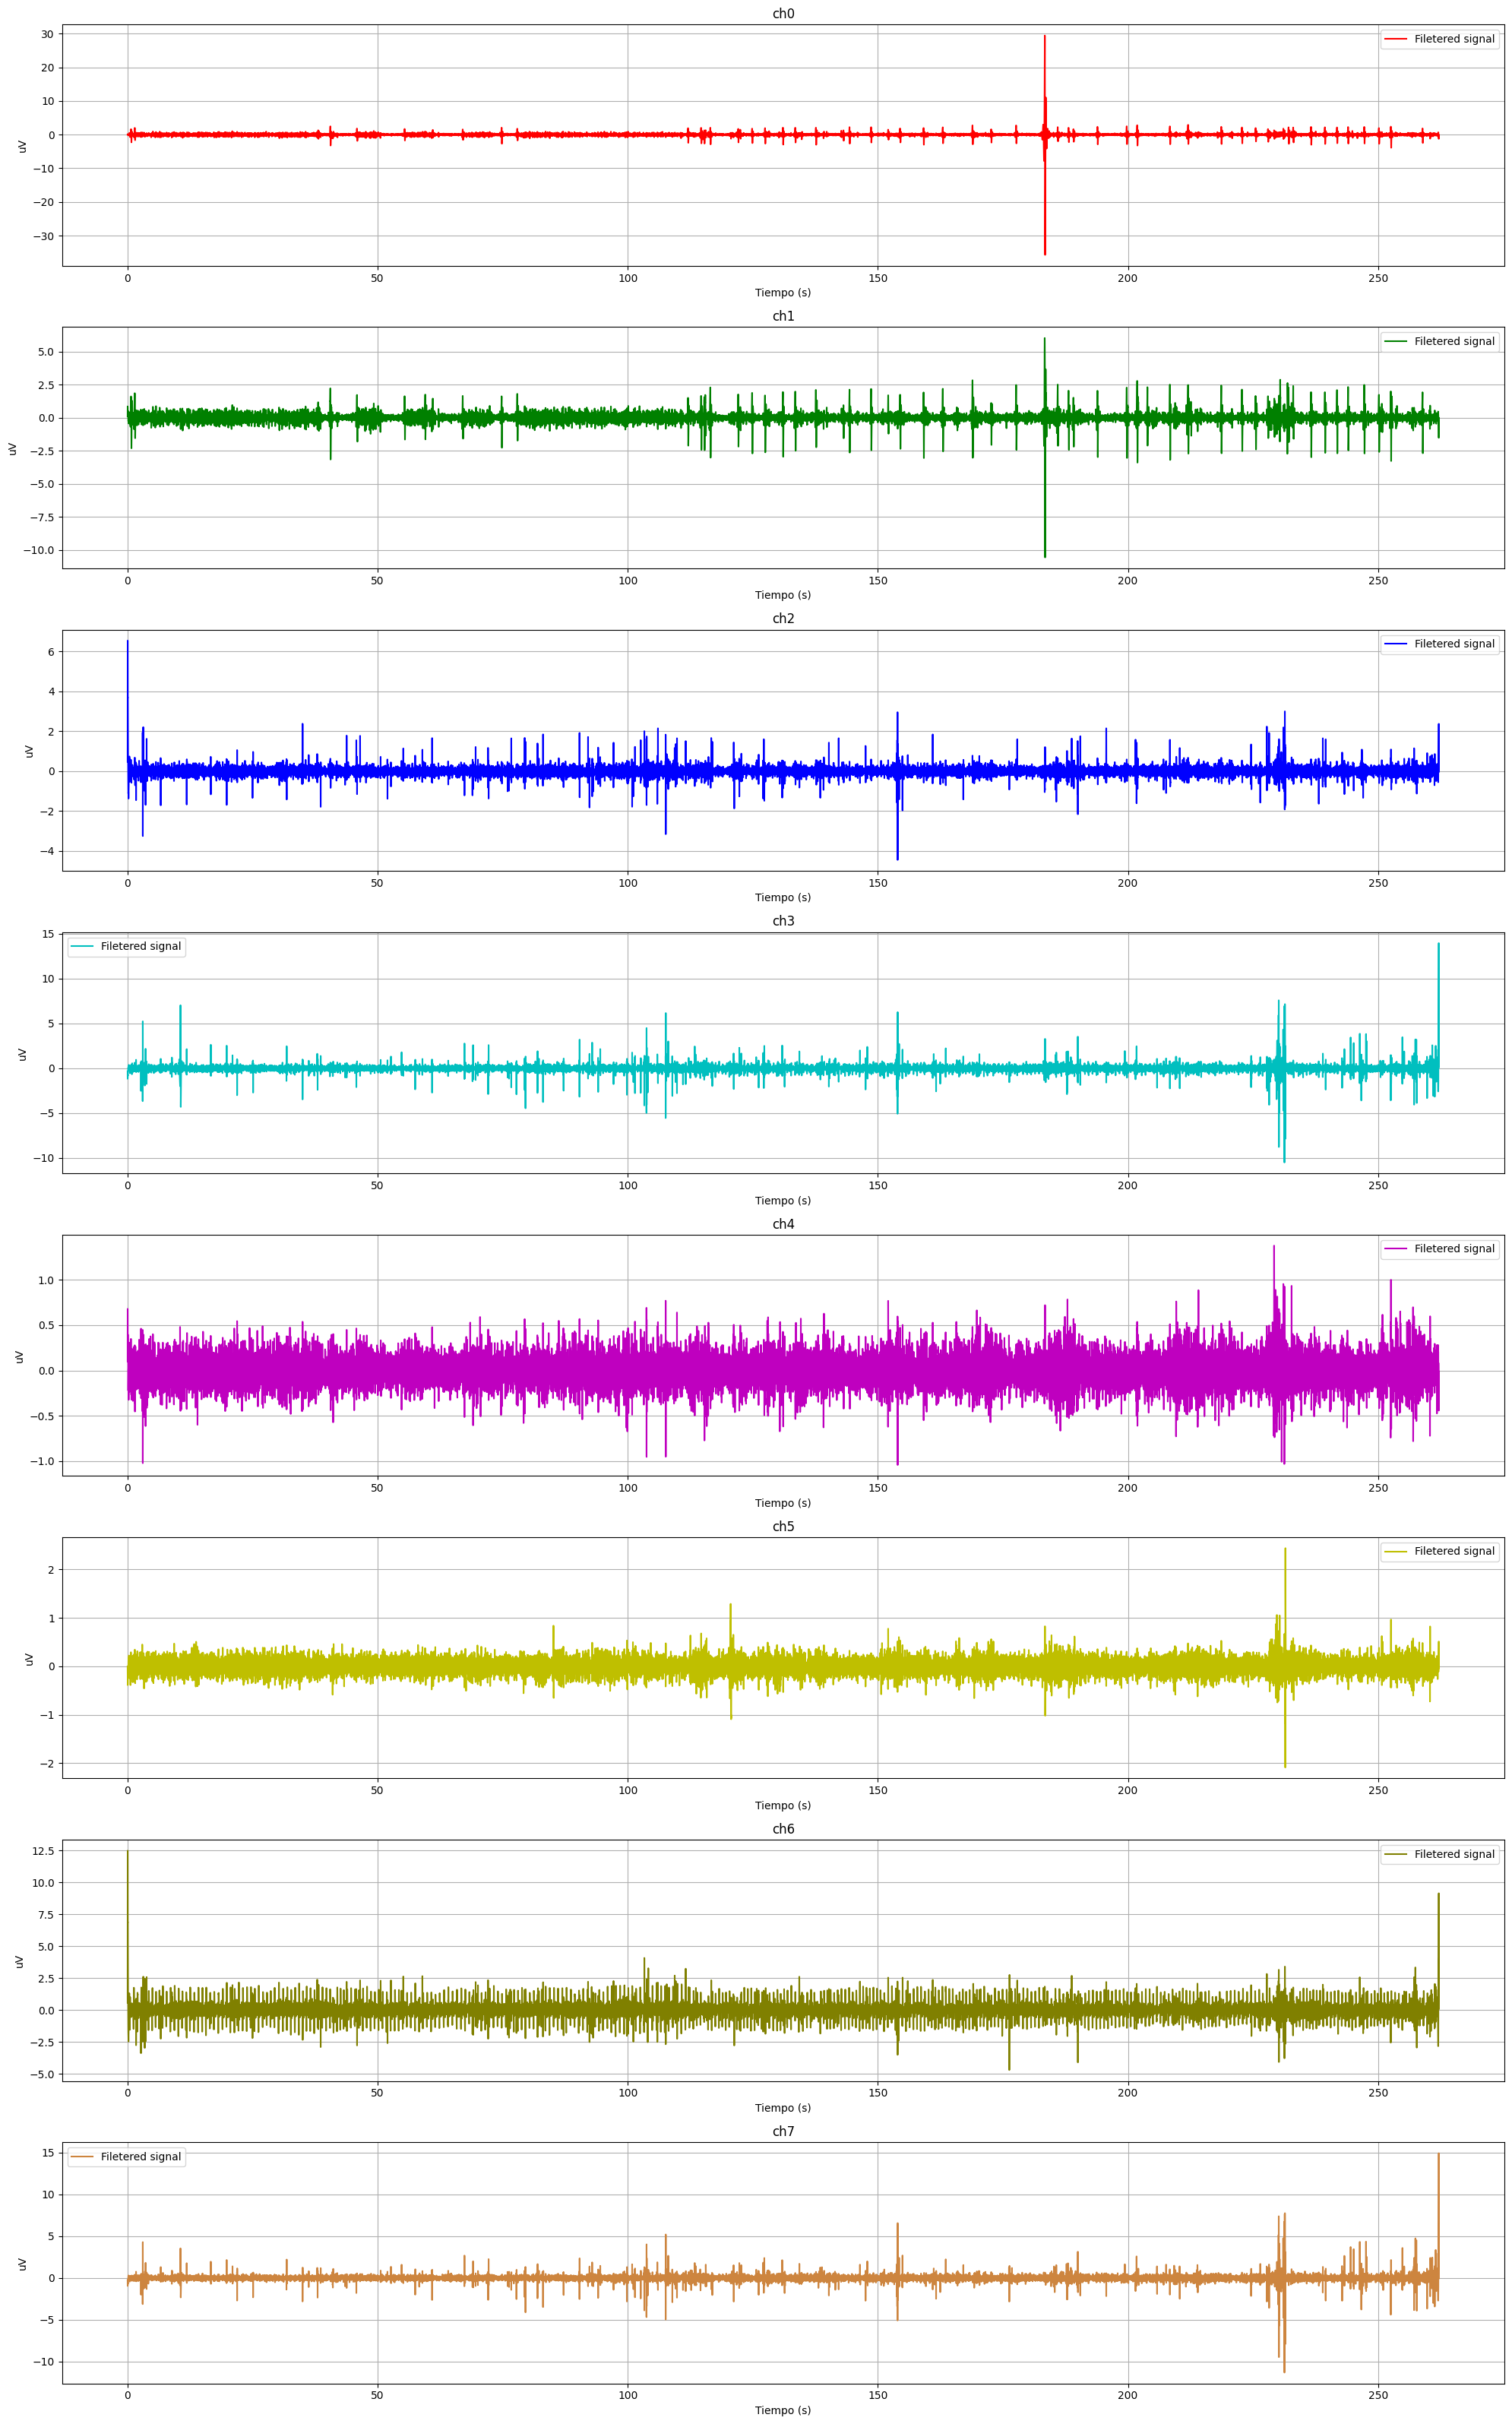

In [23]:
low_cutoff_wide = 3
high_cutoff_wide = 30

colors = ['r','g','b','c','m','y','olive', 'peru']
fig, axs = plt.subplots(len(chs), 1, figsize=(20,32))
a = 0; smooth_chs = []
for ch in chs:
    co = colors[a]
    ch = butter_bandpass_filter(ch, low_cutoff_wide, high_cutoff_wide, fs)
    smooth_chs.append(ch)
    axs[a].plot(time,ch,co, label = 'Filetered signal'); axs[a].grid(True); axs[a].set(title = 'ch' + str(a), xlabel = 'Tiempo (s)', ylabel = 'uV')
    axs[a].legend()
    a += 1
plt.tight_layout()
plt.show()

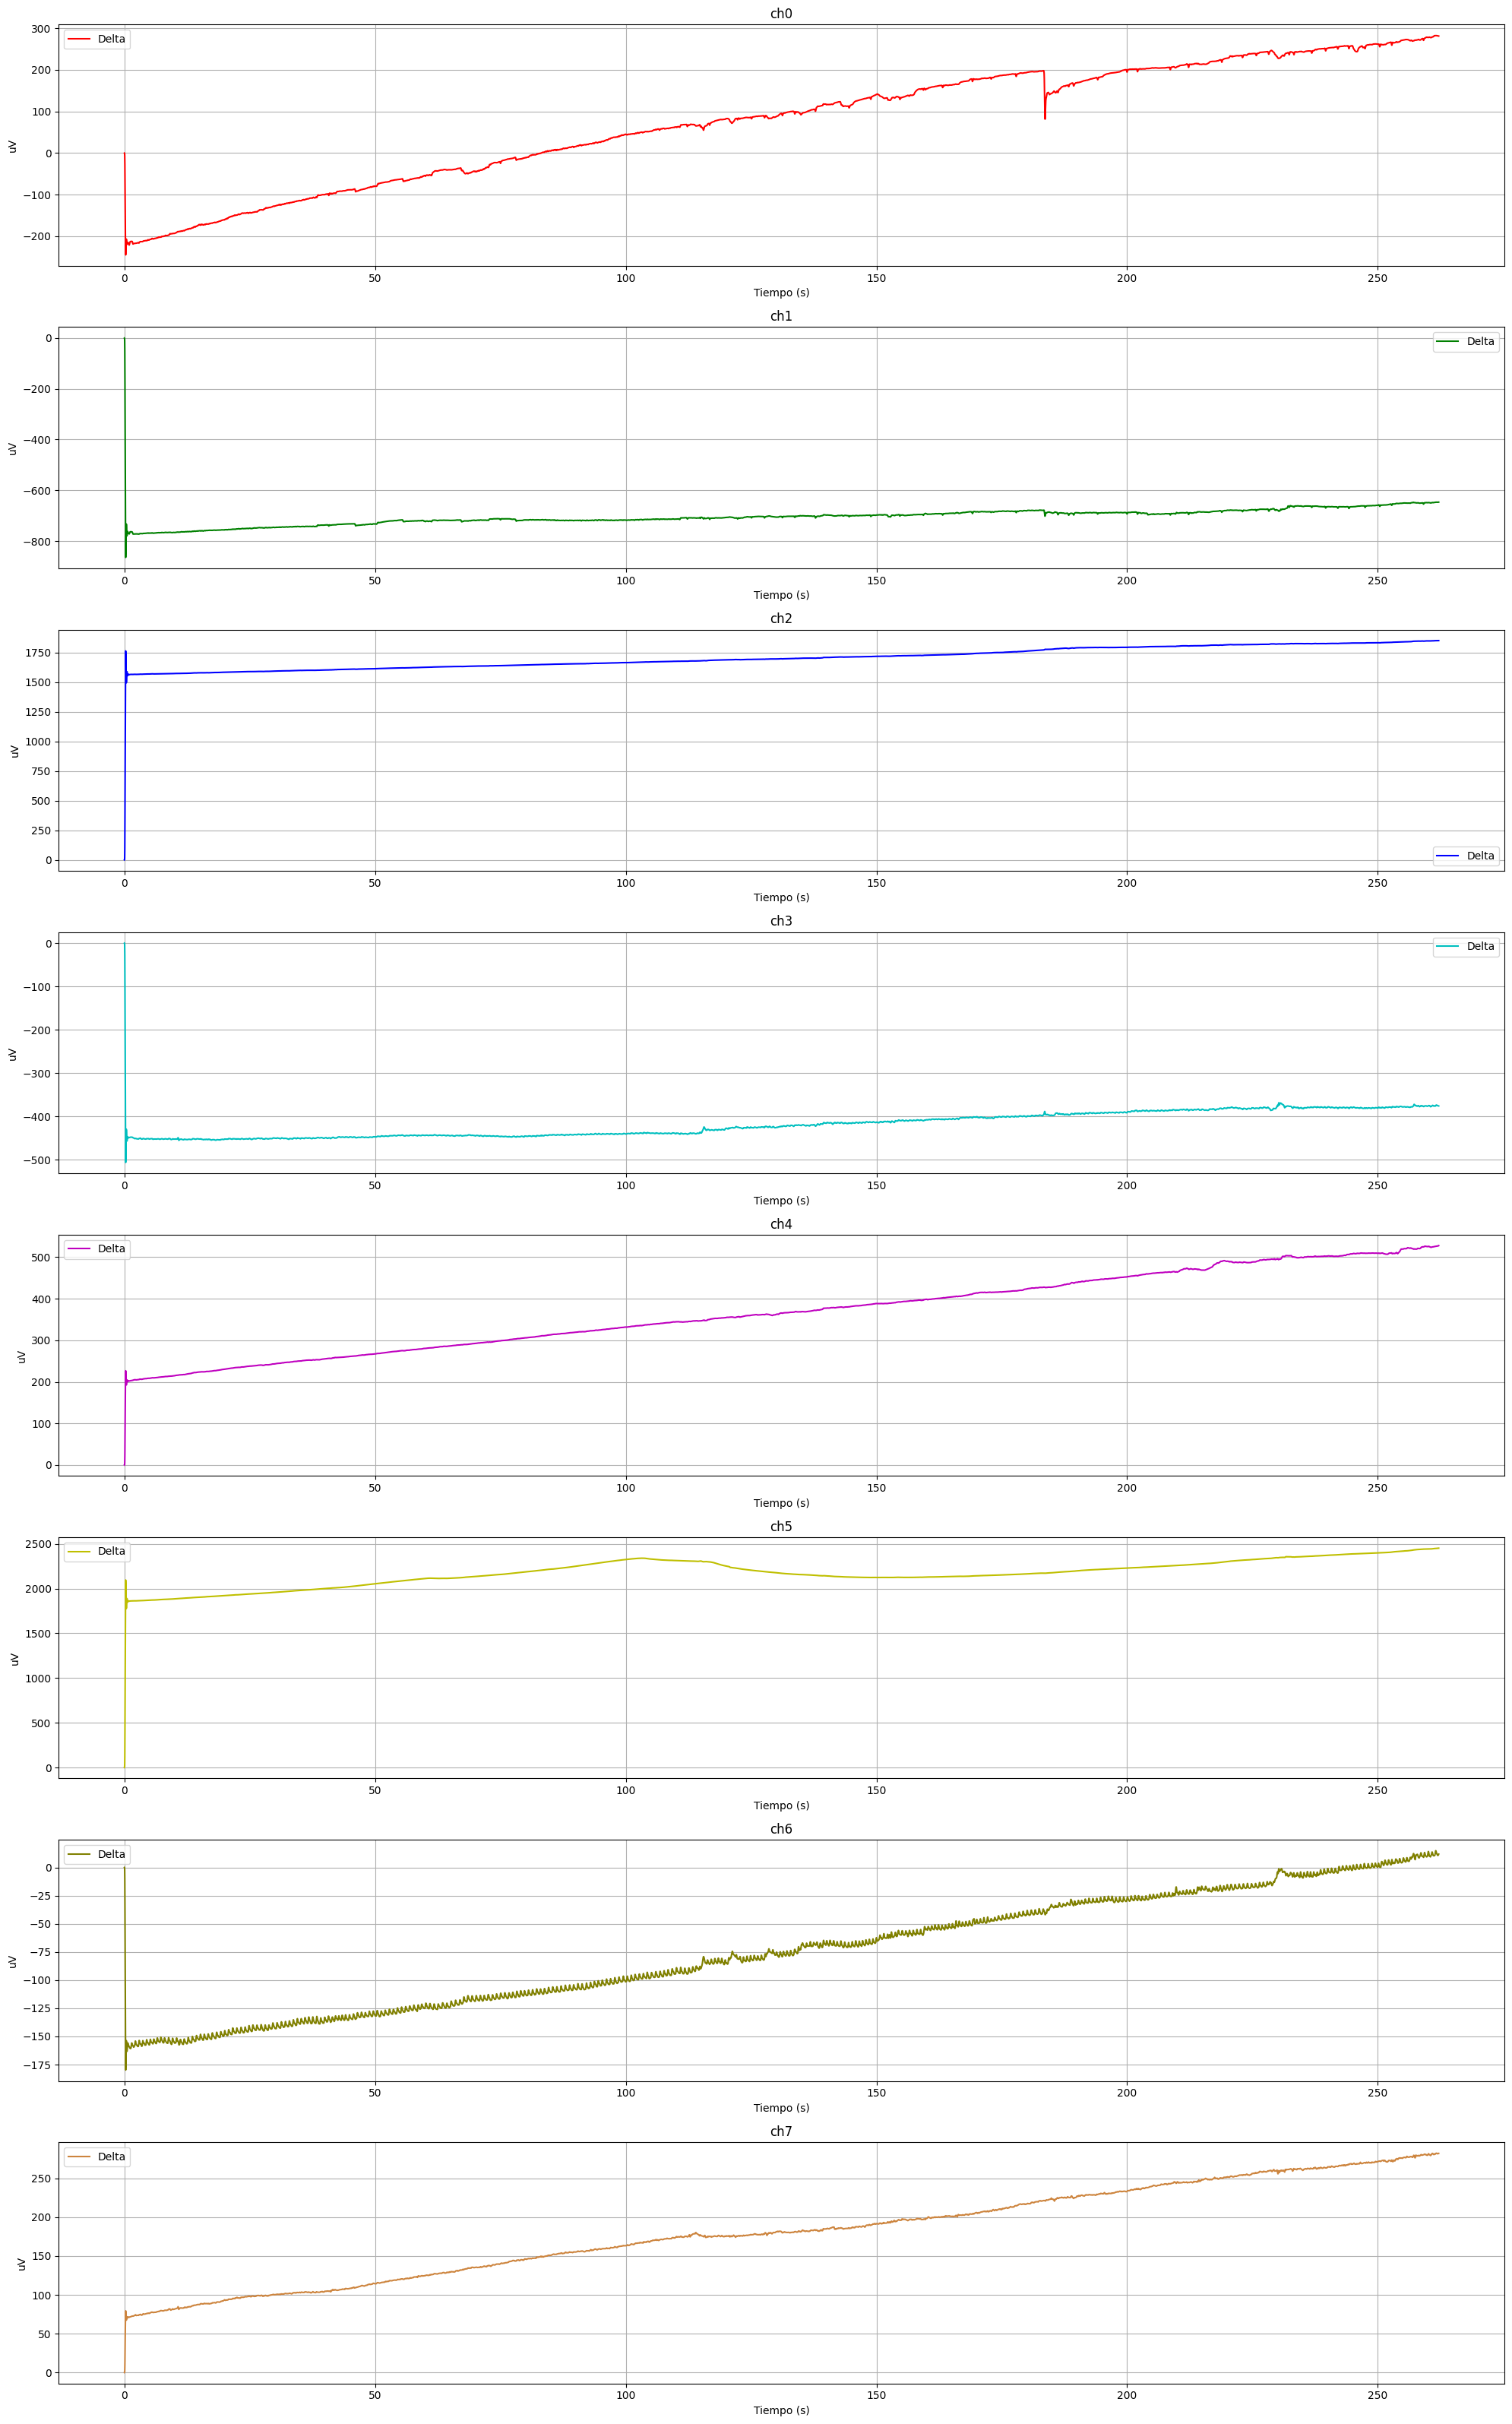

In [24]:
# Extracción de ondas delta:

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs  # frecuencia de Nyquist
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


low_cutoff_wide = 4

colors = ['r','g','b','c','m','y','olive', 'peru']
fig, axs = plt.subplots(len(chs), 1, figsize=(20,32))
a = 0
for ch in chs:
    co = colors[a]
    ch = butter_lowpass_filter(ch, low_cutoff_wide, fs)
    axs[a].plot(time,ch,co, label = 'Delta'); axs[a].grid(True); axs[a].set(title = 'ch' + str(a), xlabel = 'Tiempo (s)', ylabel = 'uV')
    axs[a].legend()
    a += 1
plt.tight_layout()
plt.show()


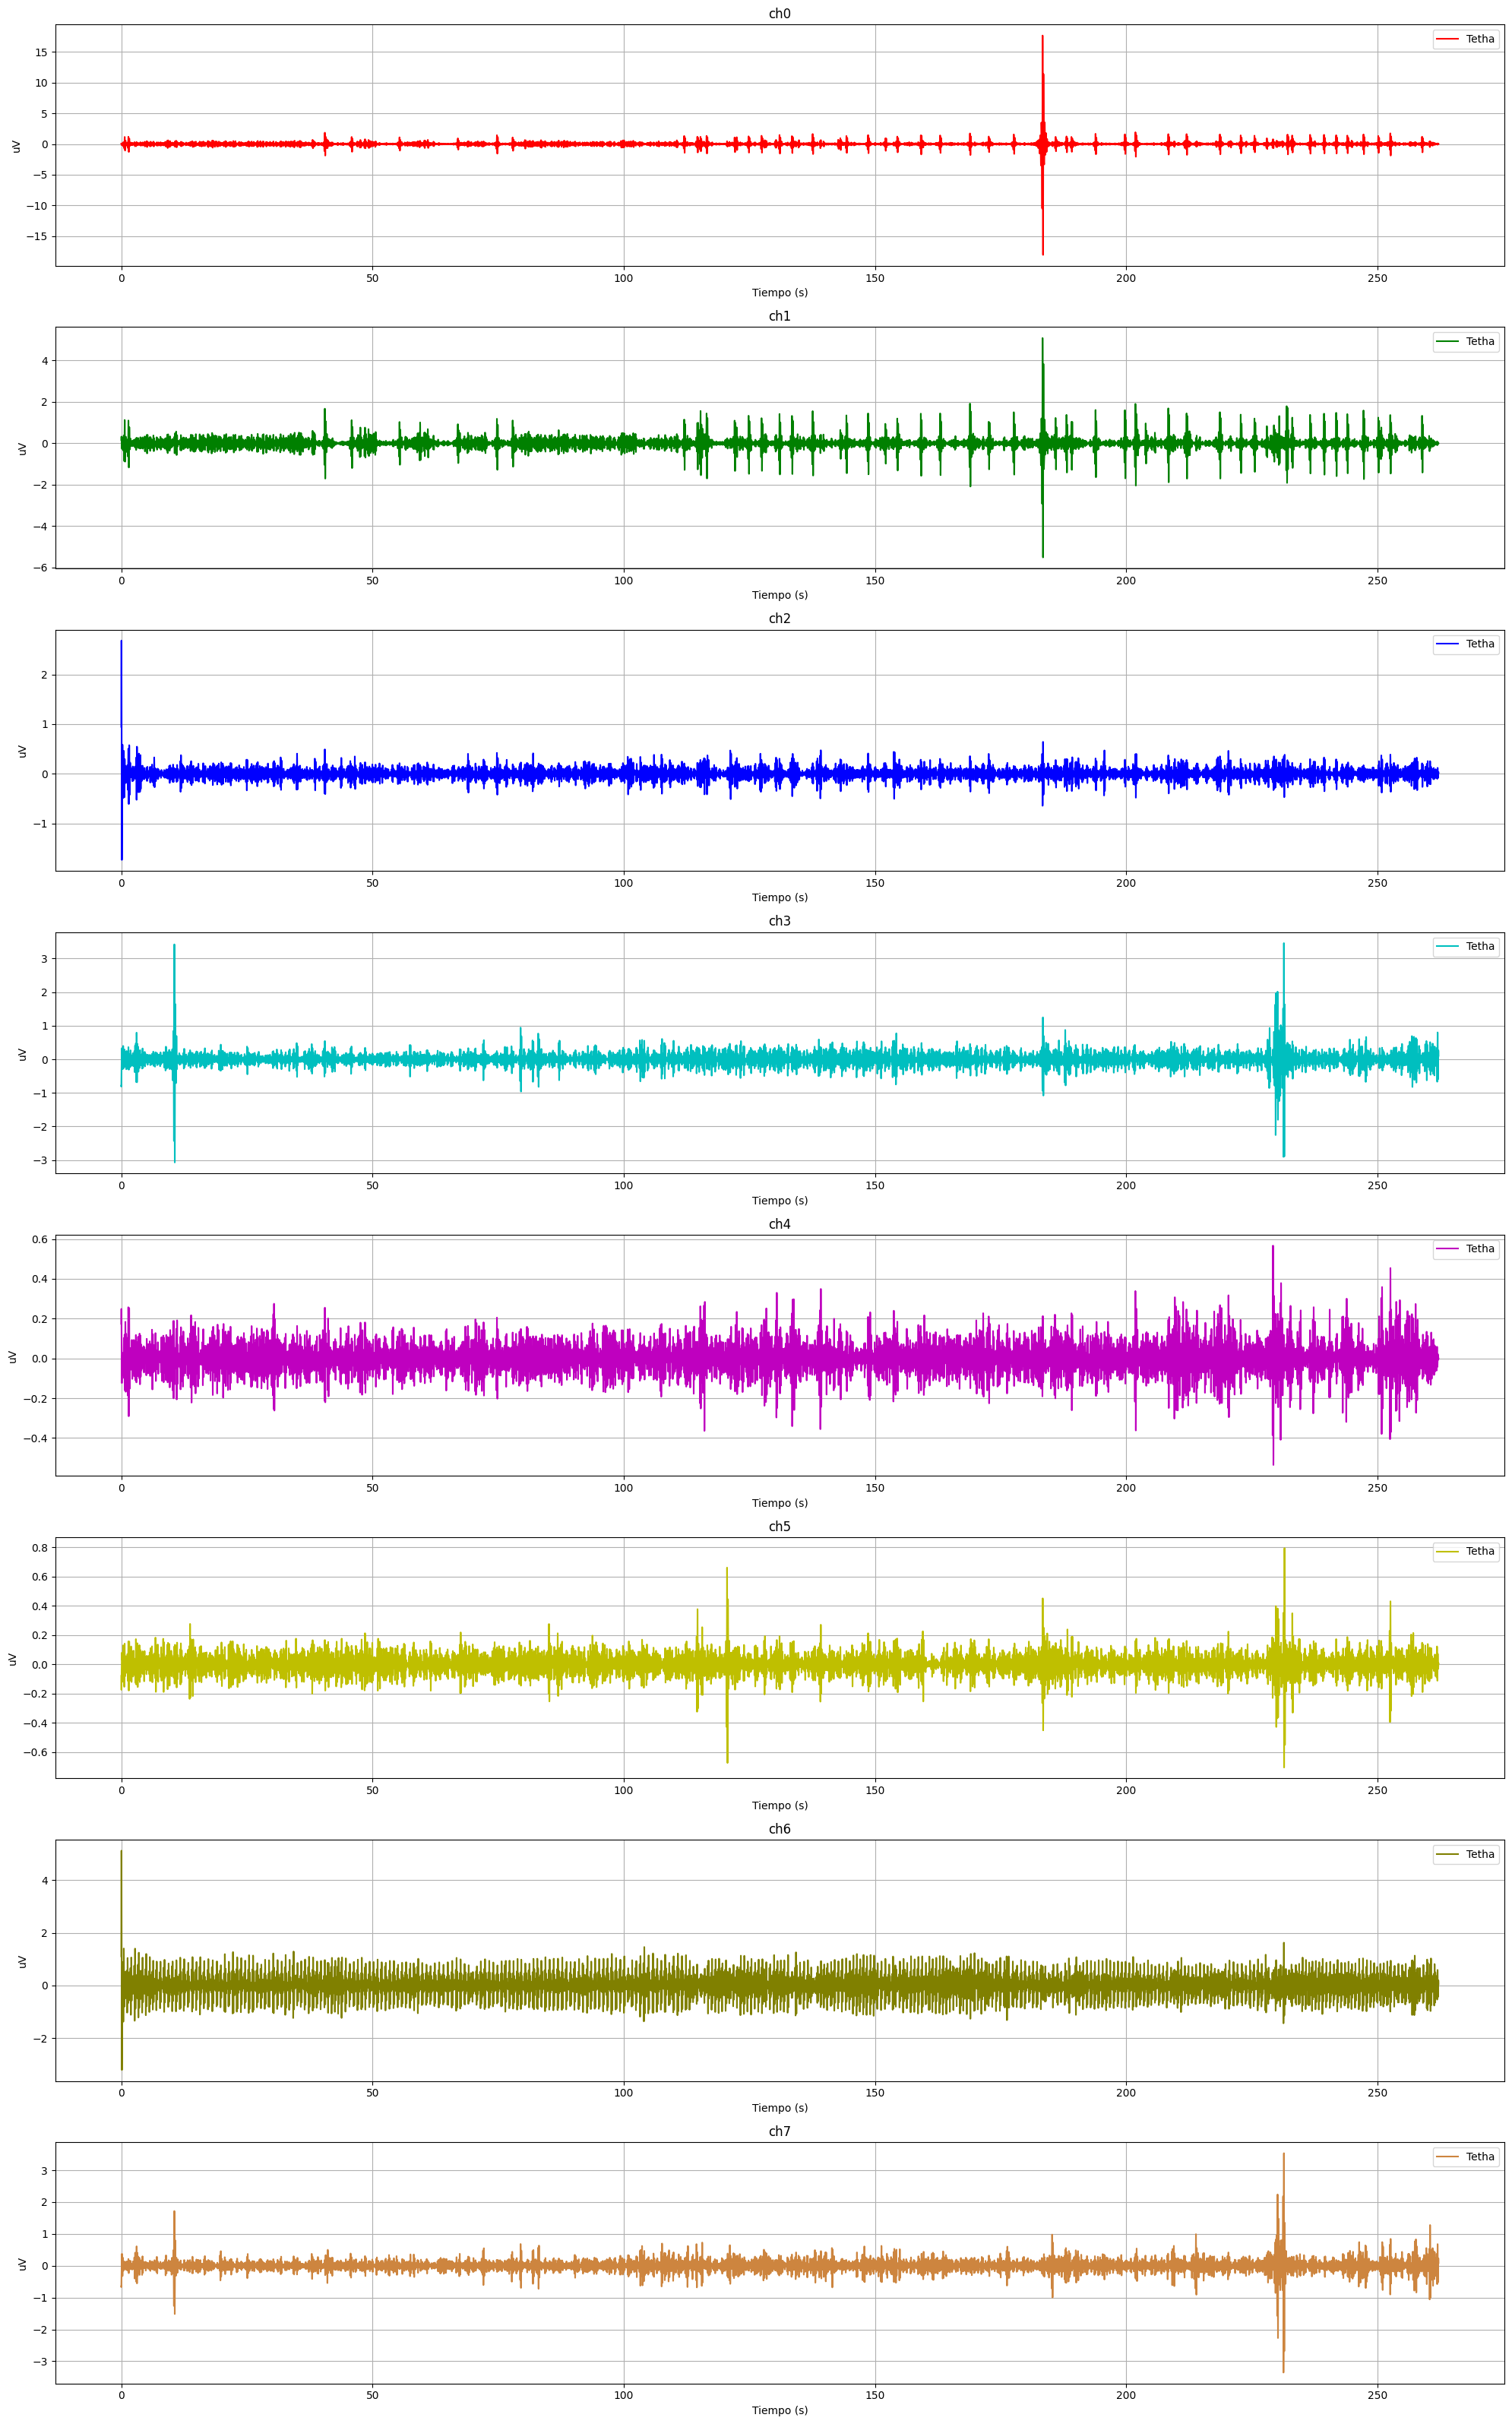

In [25]:
# Extracción de ondas thetha:

low_cutoff_wide = 4
high_cutoff_wide = 8

colors = ['r','g','b','c','m','y','olive', 'peru']
fig, axs = plt.subplots(len(chs), 1, figsize=(20,32))
a = 0
for ch in chs:
    co = colors[a]
    ch = butter_bandpass_filter(ch, low_cutoff_wide, high_cutoff_wide, fs)
    axs[a].plot(time,ch,co, label = 'Tetha'); axs[a].grid(True); axs[a].set(title = 'ch' + str(a), xlabel = 'Tiempo (s)', ylabel = 'uV')
    axs[a].legend()
    a += 1
plt.tight_layout()
plt.show()


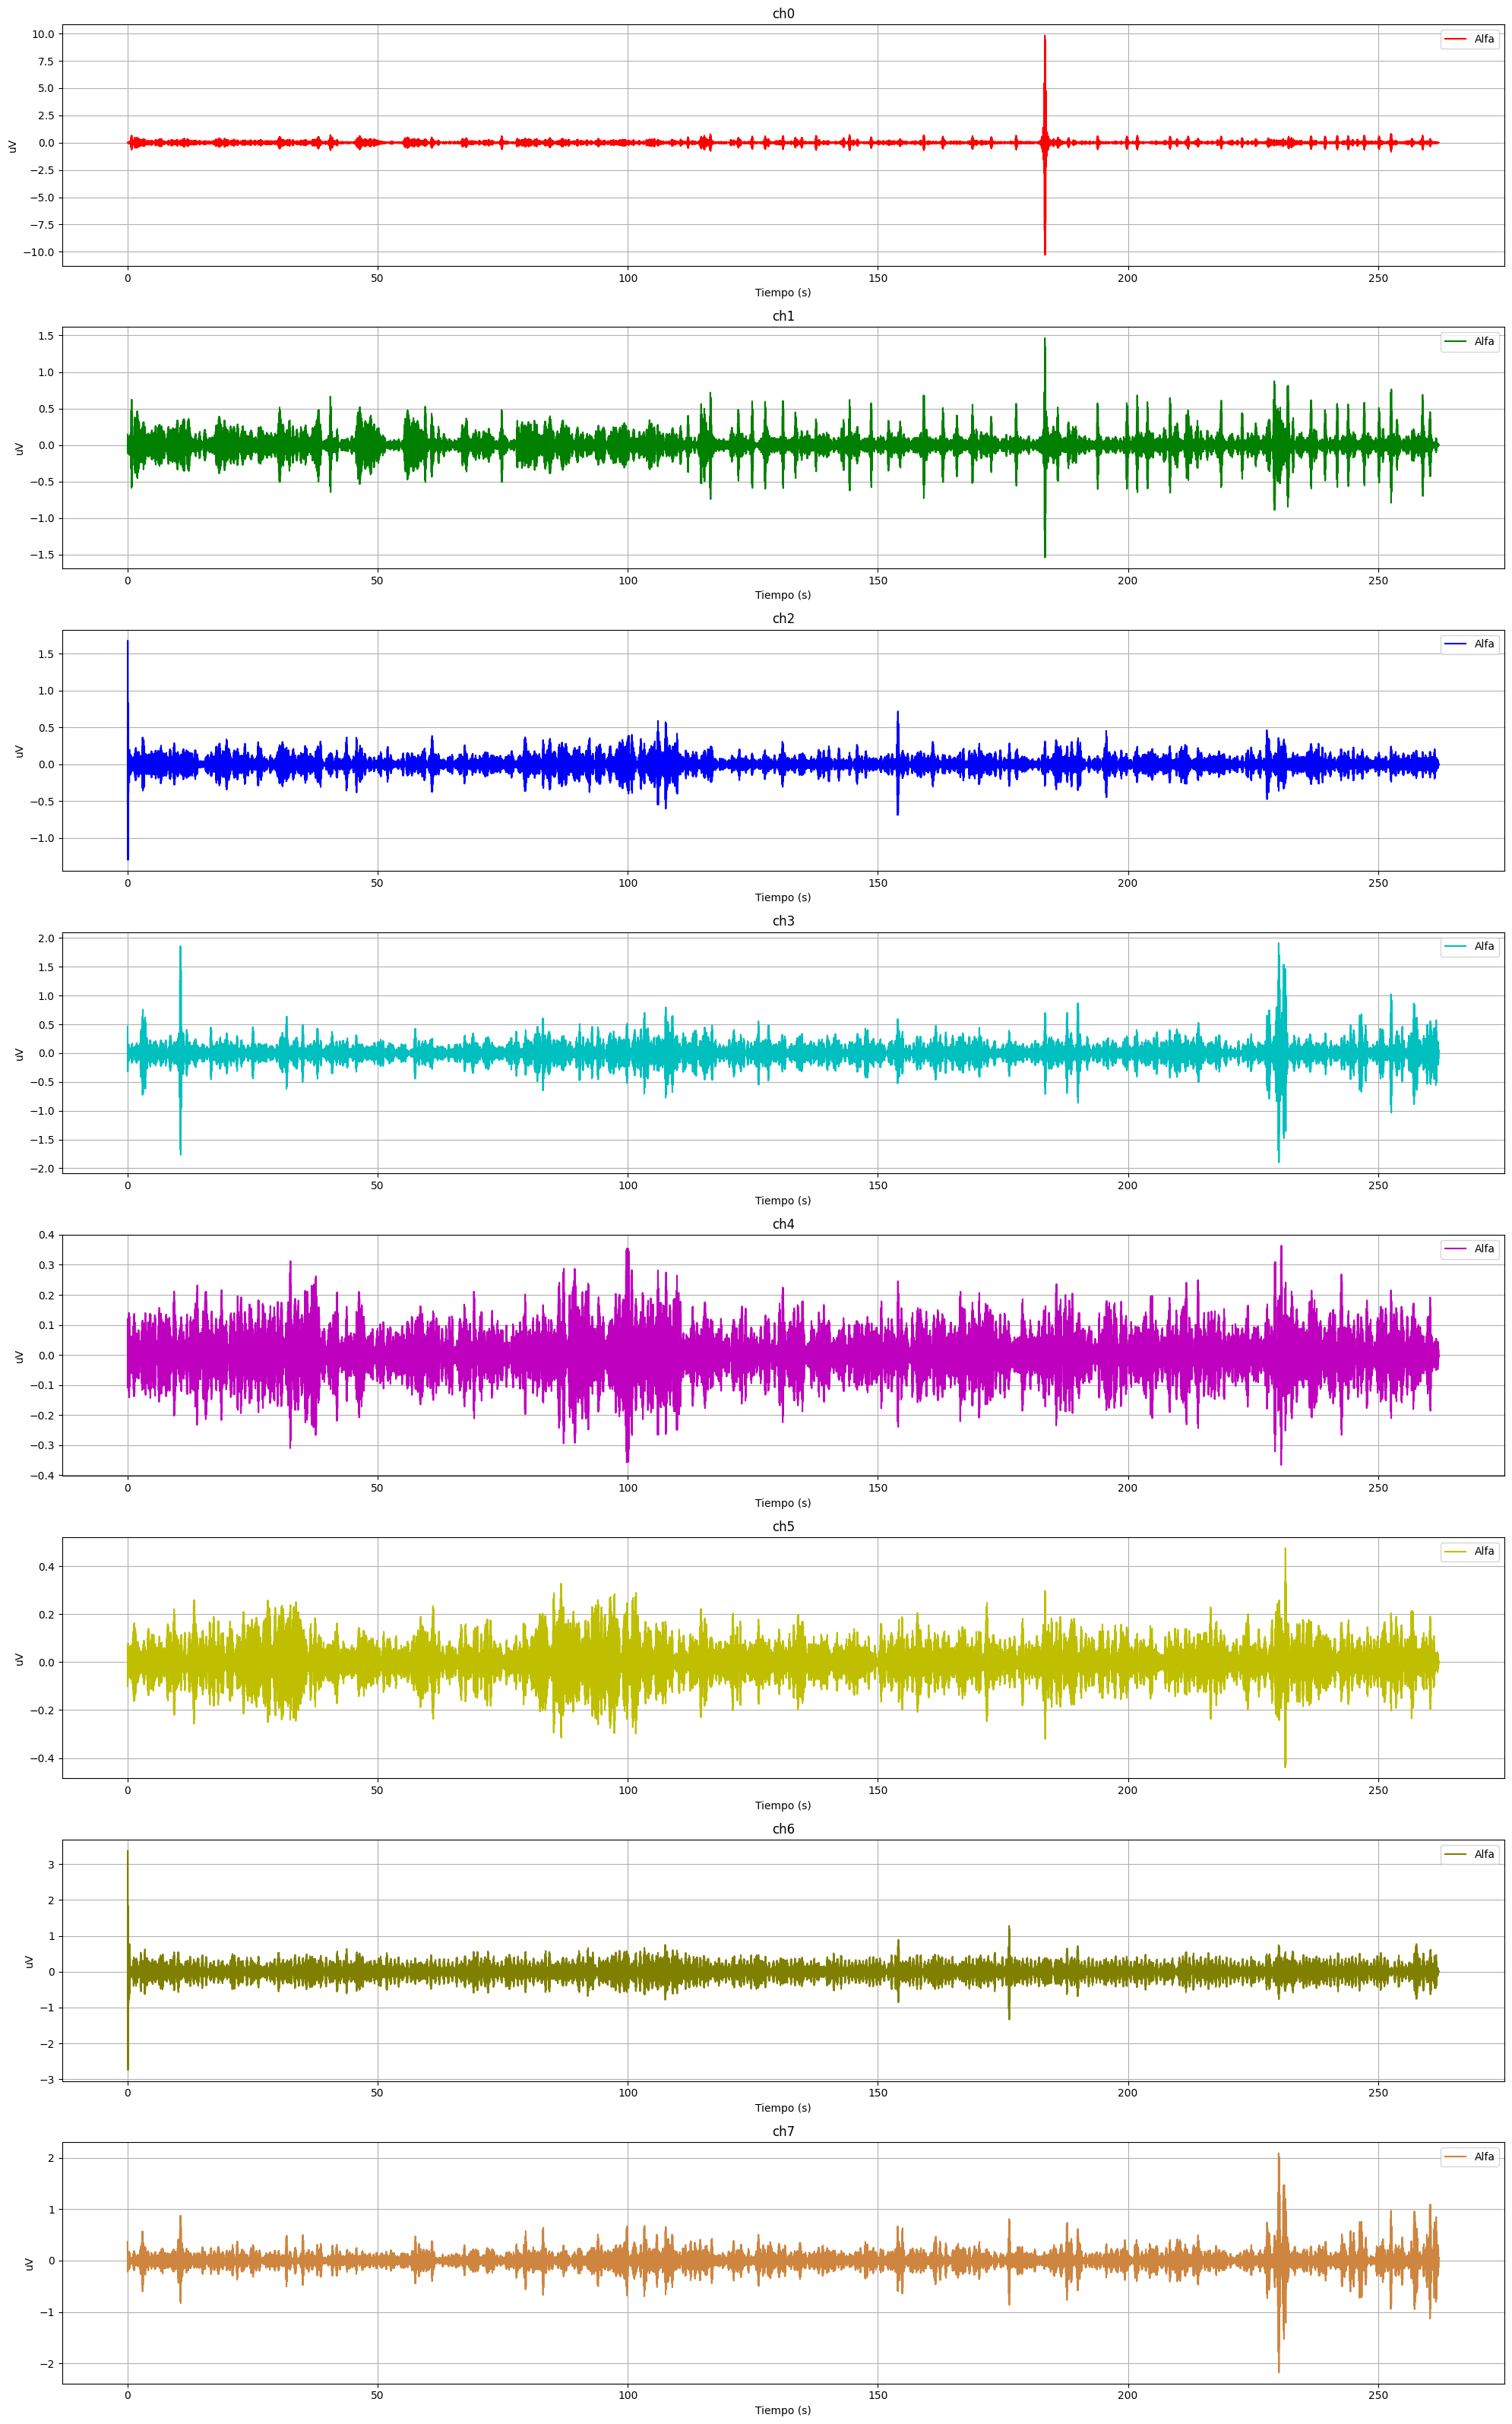

In [26]:
# Extracción de ondas alfa:

low_cutoff_wide = 8
high_cutoff_wide = 12

colors = ['r','g','b','c','m','y','olive', 'peru']
fig, axs = plt.subplots(len(chs), 1, figsize=(20,32))
a = 0
for ch in chs:
    co = colors[a]
    ch = butter_bandpass_filter(ch, low_cutoff_wide, high_cutoff_wide, fs)
    axs[a].plot(time,ch,co, label = 'Alfa'); axs[a].grid(True); axs[a].set(title = 'ch' + str(a), xlabel = 'Tiempo (s)', ylabel = 'uV')
    axs[a].legend()
    a += 1
plt.tight_layout()
plt.show()


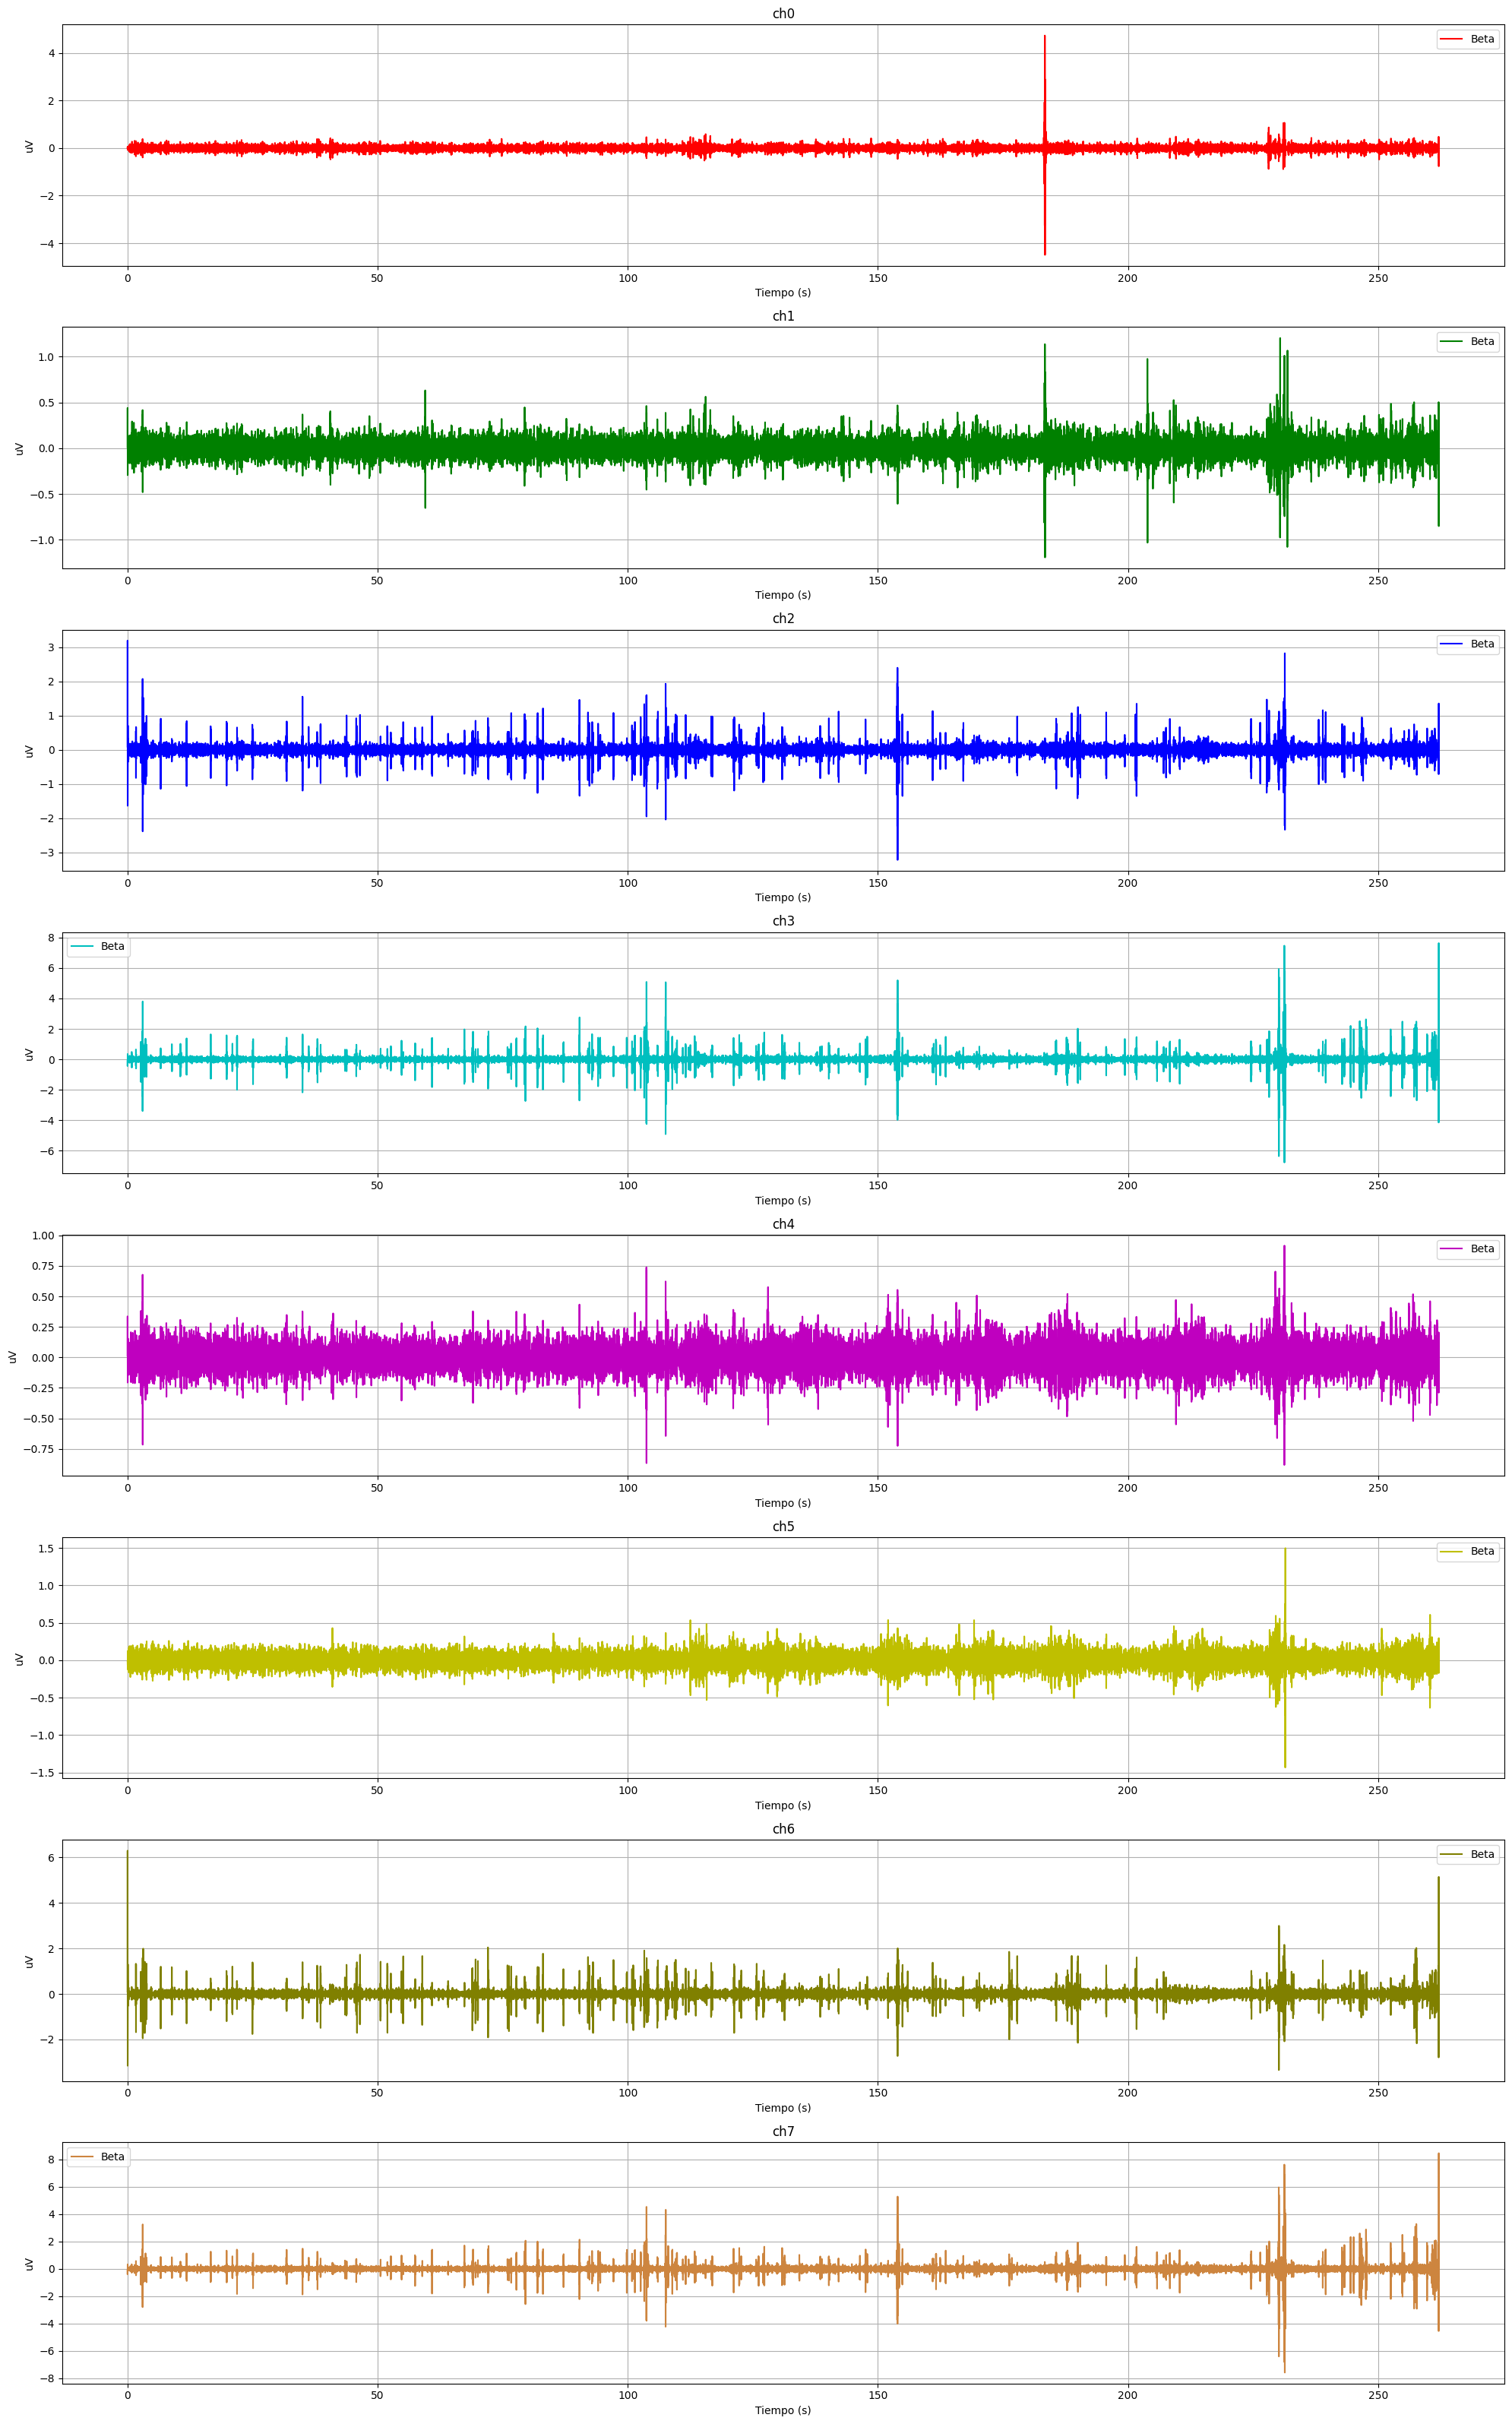

In [27]:
# Extracción de ondas Beta:

low_cutoff_wide = 13
high_cutoff_wide = 30

colors = ['r','g','b','c','m','y','olive', 'peru']
fig, axs = plt.subplots(len(chs), 1, figsize=(20,32))
a = 0
for ch in chs:
    co = colors[a]
    ch = butter_bandpass_filter(ch, low_cutoff_wide, high_cutoff_wide, fs)
    axs[a].plot(time,ch,co, label = 'Beta'); axs[a].grid(True); axs[a].set(title = 'ch' + str(a), xlabel = 'Tiempo (s)', ylabel = 'uV')
    axs[a].legend()
    a += 1
plt.tight_layout()
plt.show()

In [28]:
# Extraemos las caracteristicas de cada canal:
a = 1; general_features = {}
for smooth_ch in smooth_chs:
    features = extract_features(smooth_ch)
    general_features.update({'CH'+str(a):features})
    a+=1
print(general_features)

{'CH1': {'media': -0.0001275956436876558, 'desviacion_estandar': 0.7349310596146946, 'amplitud': 65.18751048423775, 'frecuencia_dominante': 951, 'potencia': 0.540123678667026, 'kurtosis': 859.4894637681081, 'wavelet': array([-4.79165697e-04, -1.50006818e-03,  3.73486236e-03, ...,
        8.00441052e-01,  1.40061624e+00, -2.23671893e+00]), 'rms': 0.7349310706910044, 'area': array([ 0.06593894,  0.13031826,  0.20347306, ..., -7.22150124,
       -8.0391381 , -8.36942538]), 'min_value': -35.73322286303238, 'max_value': 29.454287621205363, 'area_freq': array([0.        , 0.00110721, 0.00488273, 0.03281911, 0.08657721,
       0.13496876, 0.16511851, 0.18290988, 0.19396998, 0.20172487,
       0.20855627, 0.21410485, 0.21748099, 0.21940124, 0.2206562 ,
       0.22165734, 0.22249826, 0.22321699, 0.22387225, 0.22449521,
       0.22504229, 0.22555901, 0.22607865, 0.22653424, 0.22692717,
       0.22730029, 0.22764122, 0.22793963, 0.22819856, 0.22840697,
       0.22855981, 0.22866798, 0.22874185, 0